# Hamiltonian Simulation using SuzukiTrotter

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Hamiltonian-Simulation-using-SuzukiTrotter" data-toc-modified-id="Hamiltonian-Simulation-using-SuzukiTrotter-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Hamiltonian Simulation using SuzukiTrotter</a></span></li><li><span><a href="#Defining-the-Hamiltonian" data-toc-modified-id="Defining-the-Hamiltonian-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Defining the Hamiltonian</a></span></li><li><span><a href="#Hamiltonian-Simulation" data-toc-modified-id="Hamiltonian-Simulation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hamiltonian Simulation</a></span></li></ul></div>

# Defining the Hamiltonian

In [ ]:
import numpy as np
from qiskit.aqua.operators import I, X, Y, Z
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

def BCS_hamiltonian(epsilons, V):
    return ((1/2*epsilons[0]*I^Z) + (1/2*epsilons[1]*Z^I) + V*(1/2*(X^X) + 1/2*(Y^Y)))

In [10]:
EPSILONS = [1,1]
V = 2
hamiltonian = BCS_hamiltonian(EPSILONS, V)
print(hamiltonian)

SummedOp([
  0.5 * IZ,
  0.5 * ZI,
  XX,
  YY
])


# Hamiltonian Simulation

In [11]:
from qiskit.aqua.operators import PauliTrotterEvolution, CircuitSampler, MatrixEvolution, Suzuki
from qiskit.aqua.operators import StateFn, Plus, Zero, One, Minus, PauliExpectation, CX
from qiskit.circuit import Parameter
from qiskit import BasicAer

In [12]:
# Initial State 
init_state = (Plus^Zero)

# Time evolution operator
evolution_param = Parameter("t")
evolution_op = (evolution_param * hamiltonian).exp_i()

# Measurement of the Hamiltonian with the time evolved state
evo_and_meas = StateFn(hamiltonian).adjoint() @ evolution_op @ init_state

# Trotterization
trotterized_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=1)).convert(evo_and_meas)

# Diagonalize the measurement
diagonalized_meas_op = PauliExpectation().convert(trotterized_op)

# Create an array to represent time and apply to the circuit
n_points = 10
time_array = list(np.linspace(0, 1/V, n_points))
expectations = diagonalized_meas_op.bind_parameters({evolution_param: time_array})

# Define Backend
backend = BasicAer.get_backend("statevector_simulator")

# Use CircuitSampler for getting energy values
sampler = CircuitSampler(backend=backend)
sampled_expectations = sampler.convert(expectations)
sampled_energies = sampled_expectations.eval()
print(f"Time:\n {time_array}")
print(f"Sampled energies after Trotterization:\n {np.real(sampled_energies)}")

Time:
 [0.0, 0.05555555555555555, 0.1111111111111111, 0.16666666666666666, 0.2222222222222222, 0.2777777777777778, 0.3333333333333333, 0.38888888888888884, 0.4444444444444444, 0.5]
Sampled energies after Trotterization:
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


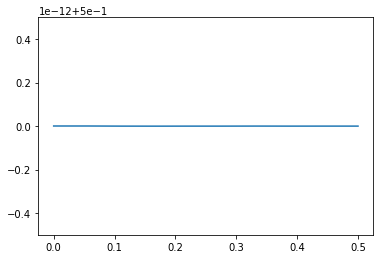

In [13]:
plt.plot(time_array, np.real(sampled_energies))
plt.show()